## Cardiovascular Risk Prediction in Cleveland Population: A Predictive Analysis of Heart Disease Occurance

## Introduction

Background: Coronary diseases pose significant health challenges, requiring precise predictive models. In Cleveland, understanding diagnostic factors is crucial. Utilizing a discriminant function model dataset, this study focuses on the relationship between age, maximum heart rate, and diagnosis levels in Cleveland. The unique healthcare landscape and lifestyle factors make this exploration essential for tailored interventions and improved cardiovascular risk assessment in the Cleveland population. Thus, this project will explore the following question: Can maximum heart rate and age be used to predict heart disease in Clevelanders?

The dataset for this analysis is derived from a discriminant function model, initially developed using clinical and noninvasive test results from 303 patients undergoing angiography at the Cleveland Clinic. Subsequently applied to diverse patient groups, the dataset encompasses variables such as age, sex, chest pain, resting blood pressure, cholesterol levels,  maximum heart rate and other relevant features for predicting diagnosis levels in the Cleveland.

## Prelim Analysis

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
# downloading and reading data, naming columns
url <- "https://raw.githubusercontent.com/ssun05/dsci_100_002_group5_project/main/processed.cleveland.data"
#download.file(url, "heart_data.csv")
heart_data <- read_csv("heart_data.csv", col_names = c("age", "sex", "chest_pain", "trestbps", "chol", "fasting_bld_sgar",
                                                      "restecg", "max_heart_rate", "exerc_angina", "oldpeak", "slope", "ca", "thal", "diagnosis"))

heart_data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, chest_pain, trestbps, chol, fasting_bld_sgar, restecg, m...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,chest_pain,trestbps,chol,fasting_bld_sgar,restecg,max_heart_rate,exerc_angina,oldpeak,slope,ca,thal,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


In [3]:
# filter for males and reclass diagnosis as factor, make labels understandable
heart_data_renamed <- heart_data |> 
                    mutate(diagnosis = as_factor(diagnosis)) |>
                    mutate(diagnosis = fct_recode(diagnosis, "none" = "0", "yes" = "1", "yes" = "2", "yes" = "3", "yes" = "4"))

heart_data_renamed

age,sex,chest_pain,trestbps,chol,fasting_bld_sgar,restecg,max_heart_rate,exerc_angina,oldpeak,slope,ca,thal,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,none
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,yes
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,yes
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,yes
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,yes
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,none


In [4]:
heart_split <- initial_split(heart_data_renamed, prop = 0.75, strata = diagnosis)

heart_train <- training(heart_split)
heart_test <- testing(heart_split)

In [5]:
# table of diagnosis counts
label_counts <- heart_train |>
                group_by(diagnosis) |>
                summarize(count = n())
label_counts

missing_data <- heart_train |> 
                filter(age == NA | max_heart_rate == NA | diagnosis == NA |
                       age == "?" | max_heart_rate == "?" | diagnosis == "?") |>
                    summarize(missing_data = n())

missing_data

diagnosis,count
<fct>,<int>
none,123
yes,104


missing_data
<int>
0


diagnosis,mean_heart
<fct>,<dbl>
none,158.8049
yes,139.1538


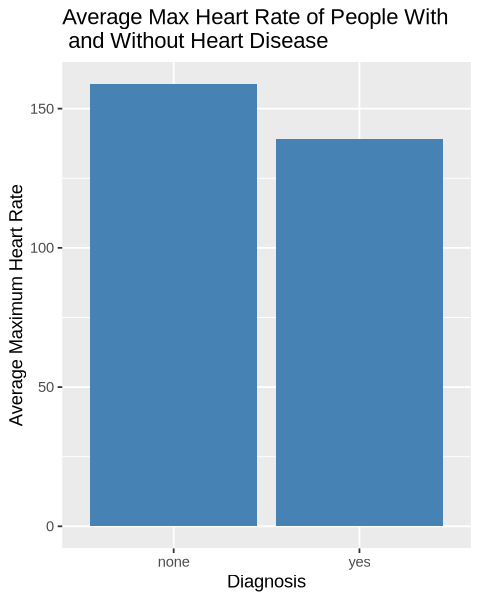

In [6]:
# predictor mean: heart rate
mean_max_hrt_rate <- heart_train |>
                        group_by(diagnosis) |>
                        summarize(mean_heart = mean(max_heart_rate))

mean_max_hrt_rate

options(repr.plot.width = 4, repr.plot.height = 5)
avg_hrt_plot <- mean_max_hrt_rate |> 
                ggplot(aes(x = diagnosis, y = mean_heart)) +
                geom_bar(stat = "identity", fill = "steelblue") +
                labs(x = "Diagnosis", y = "Average Maximum Heart Rate") +
                ggtitle("Average Max Heart Rate of People With \n and Without Heart Disease")

avg_hrt_plot

diagnosis,mean_age
<fct>,<dbl>
none,52.51220
yes,56.55769


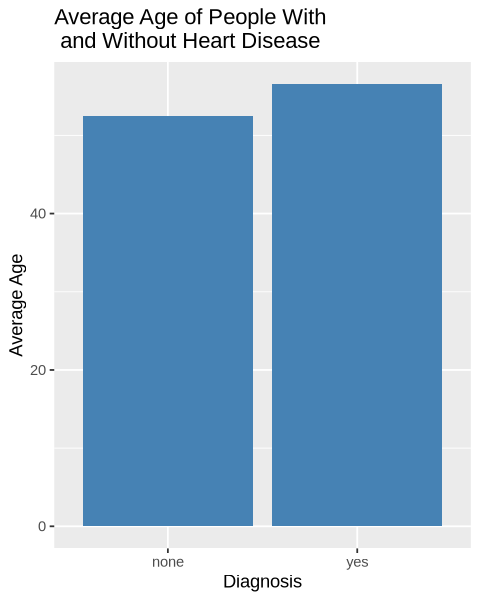

In [7]:
# predictor mean: age
mean_age <- heart_train |>
                group_by(diagnosis) |>
                summarize(mean_age = mean(age))

mean_age

options(repr.plot.width = 4, repr.plot.height = 5)
avg_hrt_plot <- mean_age |> 
                ggplot(aes(x = diagnosis, y = mean_age)) +
                geom_bar(stat = "identity", fill = "steelblue") +
                labs(x = "Diagnosis", y = "Average Age") +
                ggtitle("Average Age of People With \n and Without Heart Disease")

avg_hrt_plot

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


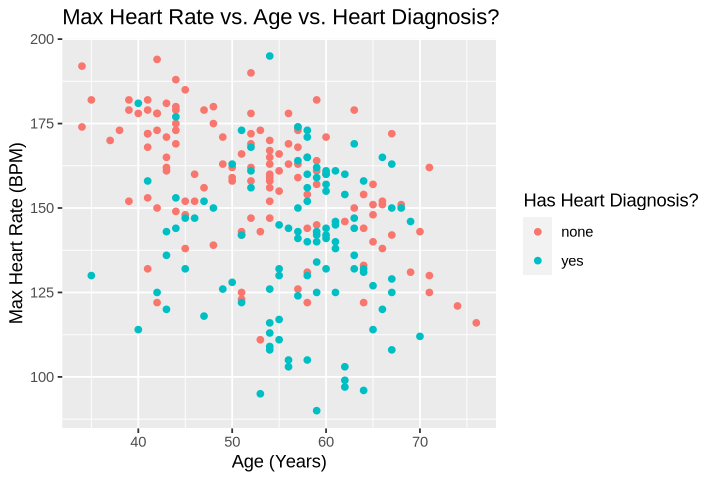

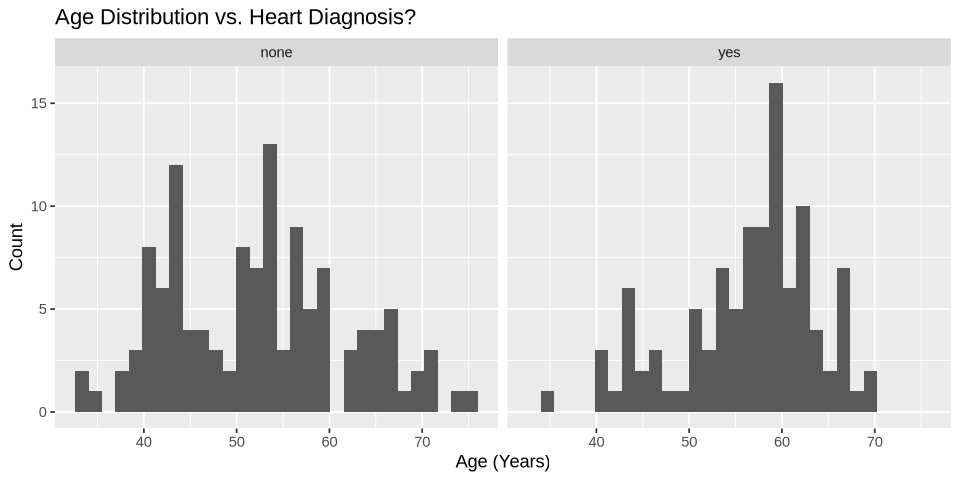

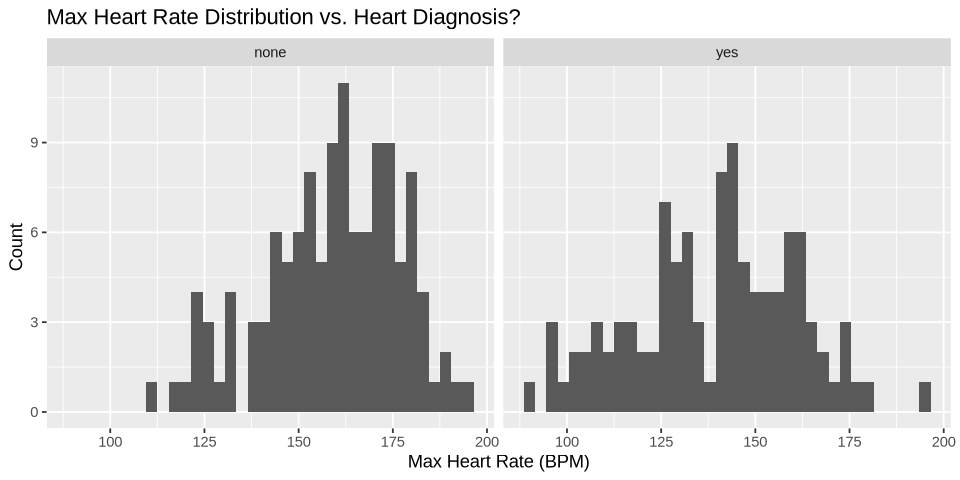

In [9]:
options(repr.plot.width = 6, repr.plot.height = 4)

heart_plot <- heart_train|> 
                ggplot(aes(x = age, y = max_heart_rate, color = diagnosis)) +
                geom_point() +
                labs(x = "Age (Years)",
                     y = "Max Heart Rate (BPM)",
                     color = "Has Heart Diagnosis?",
                     title = "Max Heart Rate vs. Age vs. Heart Diagnosis?")

heart_plot

options(repr.plot.width = 8, repr.plot.height = 4)

age_distribution <- heart_train|> 
                ggplot(aes(x = age)) +
                geom_histogram() +
                labs(x = "Age (Years)",
                     y = "Count",
                     title = "Age Distribution vs. Heart Diagnosis?") +
                facet_grid(cols = vars(diagnosis))

age_distribution

max_distribution <- heart_train|> 
                ggplot(aes(x = max_heart_rate)) +
                geom_histogram(binwidth = 3) +
                labs(x = "Max Heart Rate (BPM)",
                     y = "Count",
                     title = "Max Heart Rate Distribution vs. Heart Diagnosis?") +
                facet_grid(cols = vars(diagnosis))

max_distribution

## Methods

This analysis will use an knn classification method in order to answer the research question. With this method we will use the variables of age and max_heart_rate as predictor variables and use diagnosis as the classifier variable. After repeated testing we have found that age and max heart rate allows for the most predictive power in this application. 

We decided to use knn classification as opposed to knn regression due to the nature of the question that we are trying to answer. Diagnosis takes on values from 0 - 4 which at first looks quantitative but it is more categorical in nature because each value represents a distinct category in which heart disease can be grouped in. In order to make this distinction more clear we decided to categorize these values into two: "no" (0) and "yes" (1 - 4) which simply indicates the presence of heart disease or not.

We will perform an analysis in order to determine the best K value that maximizes our recall. If there is a person with heart disease out there we want to be sure that they get identified. We want to minimize the amount of false negatives.

Finally to build our classifier we will create an workflow that contains an recipe, that scales and centers all predictors, and a model.

To visualize our results we will use a confusion matrix that summarizes the predictions that our classifier has made.

## Expected Outcomes and Significance

We are expecting that population with younger ages and higher maximum heart rates wil tend to have lower risk of heart disease occurance, while elder population with lower maximum heart rates will tend to have higher risk of heart disease occurance.

Significance: Medical professionals may use this information to tailor preventive strategies, emphasizing lifestyle modifications for high-risk groups. Also, these findings could influence healthcare policy and interventions, directing resources and preventive measures toward populations with higher risk factors. Further research could explore which factor have more influence on the heart disease occurance, and evaluate the effectiveness of interventions based on age and maximum heart rates. 
